# Data Preparation for Feature-Based Cluster Queries

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
import math
import numpy as np

from matplotlib import pyplot as plt

In [50]:
chrom = 'chr7'
bin_size = 100000

cluster_tsv_file = '../data/hg19/gm12878_triplets_chr7_100kb_pooled.tsv.gz'
cluster_h5_file = '../data/hg19/gm12878_triplets_chr7_100kb_pooled.h5'

pairs_tsv_file = '../data/hg19/Rao2014-GM12878-MboI-allreps-filtered-chr7-read-pairs.100kb.tsv.gz'
pairs_tsv_file_updated = '../data/hg19/Rao2014-GM12878-MboI-allreps-filtered-chr7-read-pairs.100kb.updated.tsv.gz'
pairs_h5_file = '../data/hg19/Rao2014-GM12878-MboI-allreps-filtered-chr7-read-pairs.100kb.h5'

chrom_sizes_file = '../data/hg19/hg19.chrom.sizes'

tads_arrowhead_bed_file = '../data/hg19/Rao_RepH_GM12878_Arrowhead.sorted.bed'
tads_arrowhead_sqlite_file = '../data/hg19/Rao_RepH_GM12878_Arrowhead.sorted.sqlite'

chromhmm_bed_file = '../data/hg19/wgEncodeBroadHmmGm12878HMM.bed.gz'
chromhmm_sqlite_file = '../data/hg19/wgEncodeBroadHmmGm12878HMM.sqlite'

subcompartments_bed_file = '../data/hg19/GSE63525_GM12878_subcompartments.bed.gz'
subcompartments_sqlite_file = '../data/hg19/GSE63525_GM12878_subcompartments.sqlite'

loop_extents_bed_file = '../data/hg19/GSE63525_GM12878_replicate_HiCCUPS_loop_extent_list.bed.gz'
loop_extents_sqlite_file = '../data/hg19/GSE63525_GM12878_replicate_HiCCUPS_loop_extent_list.sqlite'

In [8]:
from hgmc.utils import get_chrom_sizes

chrom_size = get_chrom_sizes(chrom_sizes_file).get(chrom)
num_bins = math.ceil(chrom_size / bin_size)

# Convert Data

### Convert Cluster TSV to H5

In [273]:
from hgmc.clusters import tsv_to_h5

tsv_to_h5(
    cluster_tsv_file,
    chrom_sizes_file,
    chrom,
    bin_size,
    header=True,
    timeit=True,
    verbose=True
)

File contains 39515493 clusters
Took 12.63 minutes


### Prepare pairwise data

In [59]:
import pandas as pd

pairs = pd.read_table(pairs_tsv_file, header=None)
pairs.head()

# Get the number of bins from chr1-chr6 as `cooler dump` outputs global bin IDs
cumsum_until_chr7 = np.sum([x[1] for x in list(get_chrom_sizes(chrom_sizes_file).items())[:6]]).astype(int)
offset_bins = np.ceil(cumsum_until_chr7 / bin_size).astype(int)

pairs.columns = ['bin1', 'bin2', 'freq']
pairs['bin1'] -= offset_bins
pairs['bin2'] -= offset_bins
pairs['chr1'] = '7'
pairs['chr2'] = '7'

diff = pairs['bin1'] != pairs['bin2']
no_trans = (pairs['bin1'] < num_bins) & (pairs['bin2'] < num_bins)

pairs = pairs[diff & no_trans]

pairs['bin1'] *= bin_size
pairs['bin2'] *= bin_size

pairs.columns = ['pos1', 'pos2', 'freq', 'chr1', 'chr2']

pairs = pairs[['chr1', 'pos1', 'chr2', 'pos2', 'freq']]

pairs.to_csv(pairs_tsv_file_updated, sep='\t', index=False, header=False)

In [62]:
import gzip

with gzip.open(pairs_tsv_file_updated, 'rt') as f:
    line = f.readline().strip()
    print(line.split('\t'))
    line = f.readline().strip()
    print(line.split('\t'))

['7', '300000', '7', '400000', '8153']
['7', '300000', '7', '500000', '1276']


In [63]:
from hgmc.clusters import tsv_to_h5

tsv_to_h5(
    pairs_tsv_file_updated,
    chrom_sizes_file,
    chrom,
    bin_size,
    cluster_size=2,
    header=True,
    timeit=True,
    verbose=True
)

File contains 1174907 clusters
Took 0.28 minutes


**Sanity Check:** The sum of the offsets should be the same as the number of bin entries

In [173]:
with h5py.File(cluster_h5_file, 'r') as h5:
    bin_offset = h5['bin_offset'][:]
    assert h5['bin_to_cluster'].shape[0] == (bin_offset[1:] - bin_offset[:-1]).sum(), \
        "The sum of the offsets should be the same as the number of bin entries!"

### Convert BED to SQL

In [176]:
from hgmc.bed import bed_to_sql
    
bed_to_sql(tads_arrowhead_bed_file, chrom_sizes_file, feature_name='tad')
bed_to_sql(chromhmm_bed_file, chrom_sizes_file)
bed_to_sql(subcompartments_bed_file, chrom_sizes_file)
bed_to_sql(loop_extents_bed_file, chrom_sizes_file, feature_name='loop')

# Basic Stats

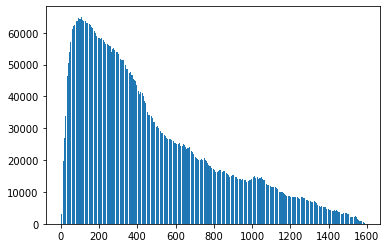

In [335]:
with h5py.File(cluster_h5_file, 'r') as h5:    
    span = h5['cluster_props'][:, 1]
    
    bins = np.arange(0, bin_size * num_bins, bin_size)
    counts = np.histogram(
        h5['cluster_props'][:, 1],
        bins=bins
    )[0]
    
    plt.bar(np.arange(counts.size), counts)